# Starbucks Capstone Project

This is the main script of the capstone project for the Udacity Data Science Nano-Degree (Jan 2020 Cohort).

The goal of this work is to investigate the data provided, then predict if someone will respond to an offer based on the type of offer provided (channel, offer type, difficulty, etc). The outcome of this project will be a machine learning model predicting if the average spend of an individual during an offer will be higher than their un-influenced average spend. 

I chose not to do a reccomender system as there are many potential combinations of types of channels, offer types, and difficulty/rewards. With the goal to not limit this exercise to only the existing short portfolio - the model produced could help tailor future offers that do not yet exist.

Note: an attempt was made to perform the below with a regression (to predict the a float for the impact of the offer, rather than a binary), however more time would be needed to explore methods to improve accuracy. At this point, the time limitations of the course require an immediate submission. 


In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as pyplot
from functions import *

In [2]:
# import datasets and clean portfolio dataset
portfolio, profile, transcript = import_data()
portfolio = clean_portfolio(portfolio)
portfolio.head()

,reward,difficulty,duration,id,mobile,web,email,social,discount,bogo,informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,0,1,1,0,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,1,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,0,1,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0,1,0,0


## Data Processing and EDA
### Portfolio Dataset

In [3]:
# establish variability of metrics in current portfolio of offers
portfolio_cols = ['reward','difficulty','duration','mobile','email','web','social','discount','bogo','informational']

for col in portfolio_cols:
    print ('Percent Variability For ' + col)
    print(portfolio[col].value_counts()/len(portfolio)*100)
    print('\n')


Percent Variability For reward
5     30.0
10    20.0
2     20.0
0     20.0
3     10.0
Name: reward, dtype: float64


Percent Variability For difficulty
10    40.0
5     20.0
0     20.0
7     10.0
20    10.0
Name: difficulty, dtype: float64


Percent Variability For duration
7     40.0
10    20.0
5     20.0
4     10.0
3     10.0
Name: duration, dtype: float64


Percent Variability For mobile
1    90.0
0    10.0
Name: mobile, dtype: float64


Percent Variability For email
1    100.0
Name: email, dtype: float64


Percent Variability For web
1    80.0
0    20.0
Name: web, dtype: float64


Percent Variability For social
1    60.0
0    40.0
Name: social, dtype: float64


Percent Variability For discount
0    60.0
1    40.0
Name: discount, dtype: float64


Percent Variability For bogo
0    60.0
1    40.0
Name: bogo, dtype: float64


Percent Variability For informational
0    80.0
1    20.0
Name: informational, dtype: float64




### Transcript Dataset

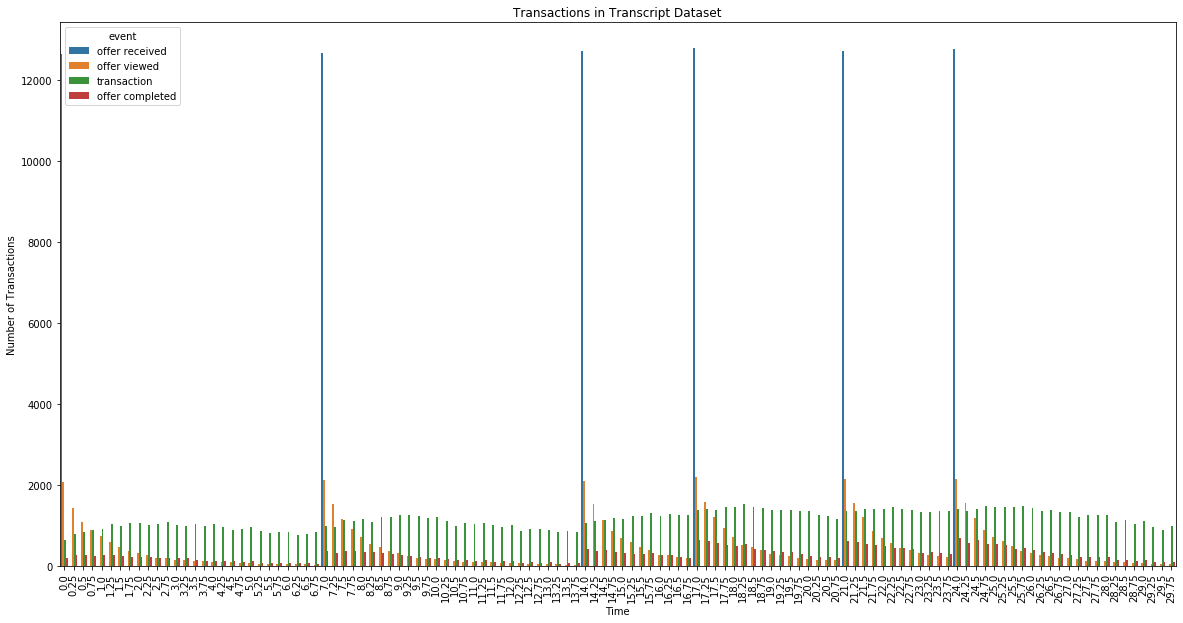

In [4]:
#what's the distribution of the time value - how are offers distributed
plt.figure(figsize=(20,10))
sns.countplot(transcript.time/24, hue = transcript.event)
plt.xticks(rotation=90)
plt.title('Transactions in Transcript Dataset')
plt.xlabel('Time')
plt.ylabel('Number of Transactions')
plt.show()

In [5]:
# are offers at distinct times?
transcript[transcript.event == 'offer received'].time.value_counts()
# yes

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [6]:
# process impact of offers on individual spending
offer_impact = calculate_offer_impact(transcript, portfolio)
offer_impact.head(20)

Importing Previously Saved Dataset


,person,offer,offer_daily_spend,no_influence_avg_daily_spend,lift
0,d2482847c5b34aefaa39f55afc669d0f,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.414167,1.226250,1.153245
1,d2482847c5b34aefaa39f55afc669d0f,2298d6c36e964ae4a3e7e9706d1fb8c2,1.162000,1.226250,0.947604
2,402c544727ae422bbe2d1ad7efcaf49a,ae264e3637204a6fb9bb56bc8210ddfd,1.164500,8.073333,0.144240
3,6ef8a5ad165246d681f4399437fa2ab9,4d5c57ea9a6940dd891ad53e9dbe8da0,5.870000,8.395882,0.699152
4,6ef8a5ad165246d681f4399437fa2ab9,ae264e3637204a6fb9bb56bc8210ddfd,4.145000,8.395882,0.493694
5,6ef8a5ad165246d681f4399437fa2ab9,2298d6c36e964ae4a3e7e9706d1fb8c2,1.642000,8.395882,0.195572
6,9be805c5483648bdb194ecc63b502f4c,5a8bc65990b245e5a138643cd4eb9837,0.620000,0.568824,1.089969
7,f97254f804b149e68d6c4b3da75e060f,2906b810c7d4411798c6938adc9daaa5,0.920000,2.947500,0.312129
8,c7a6bf2558554bf5954ed506eb3968f1,ae264e3637204a6fb9bb56bc8210ddfd,0.668571,2.900000,0.230542
9,c7a6bf2558554bf5954ed506eb3968f1,f19421c1d4aa40978ebb69ca19b0e20d,0.510000,2.900000,0.175862


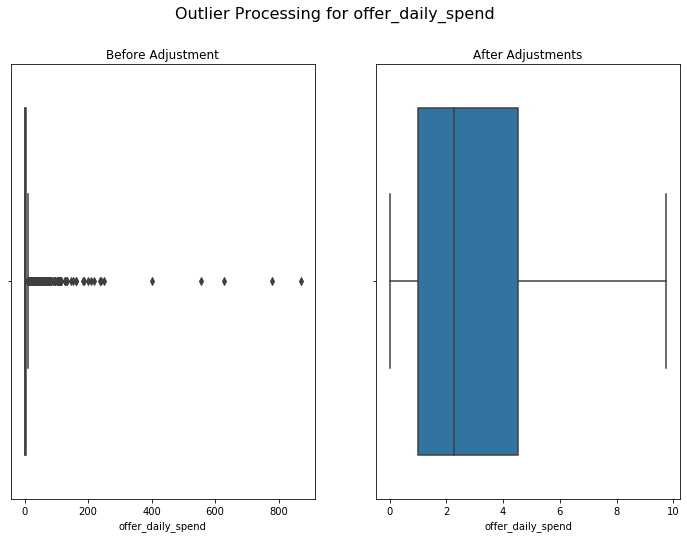

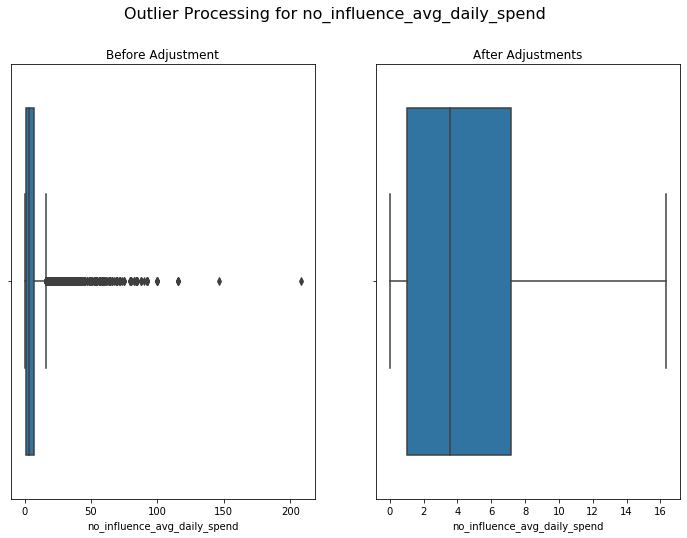

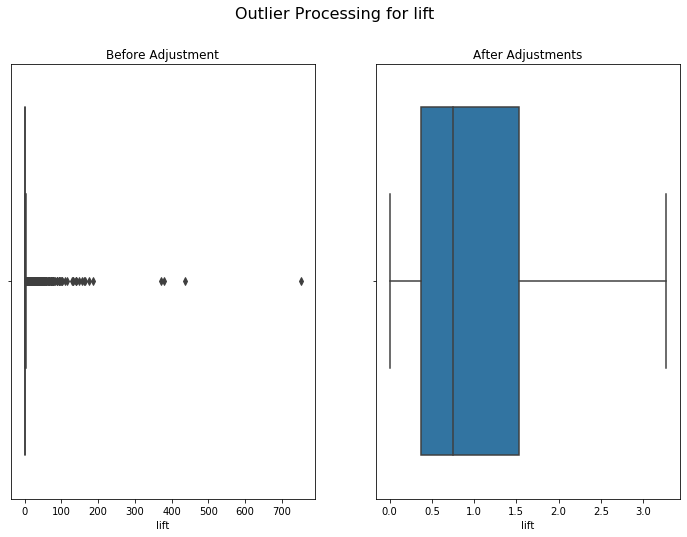

In [7]:
for col in ['offer_daily_spend', 'no_influence_avg_daily_spend','lift']:
    offer_impact[col] = IQR_adjustment(offer_impact[col],col)
    

In [8]:
# check impact of offers for one individual
tmp = offer_impact.loc[offer_impact.person =='a5c15f41f7ed4c3289ebb87b23bb1fff']
tmp

,person,offer,offer_daily_spend,no_influence_avg_daily_spend,lift
17,a5c15f41f7ed4c3289ebb87b23bb1fff,3f207df678b143eea3cee63160fa8bed,9.755625,6.616316,1.723769
18,a5c15f41f7ed4c3289ebb87b23bb1fff,4d5c57ea9a6940dd891ad53e9dbe8da0,3.472857,6.616316,0.524893
19,a5c15f41f7ed4c3289ebb87b23bb1fff,fafdcd668e3743c1bb461111dcafc2a4,5.560000,6.616316,0.840347


This is a good indication of two offers having a negative impact, while one offer has a significant impact (almost doubling spending)

In [9]:
# which offers was this person exposed to? 
tmp.loc[:,['offer','lift']].merge(portfolio,how = 'left',left_on = 'offer',right_on = 'id')

,offer,lift,reward,difficulty,duration,id,mobile,web,email,social,discount,bogo,informational
0,3f207df678b143eea3cee63160fa8bed,1.723769,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
1,4d5c57ea9a6940dd891ad53e9dbe8da0,0.524893,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,0,1,0
2,fafdcd668e3743c1bb461111dcafc2a4,0.840347,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,0,0


it looks as though the two offers with low lift were high difficulty items. Lets look at a correlation plot for lift relative to portfolio metrics

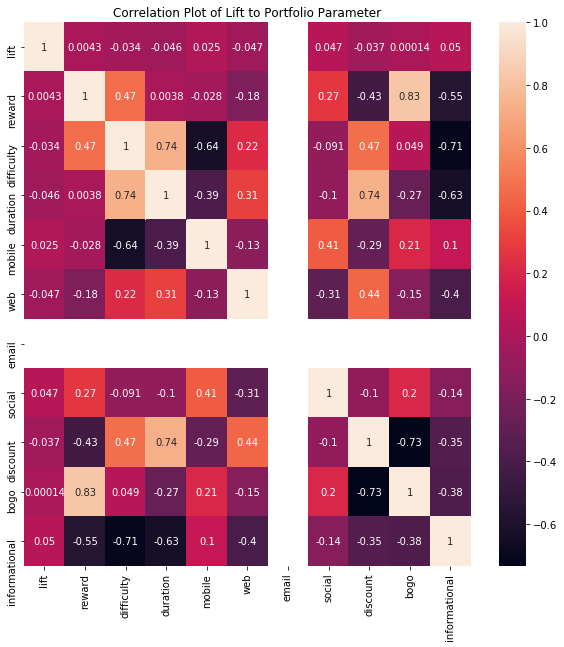

In [10]:
df_tmp = offer_impact.merge(portfolio,how = 'left',left_on = 'offer',right_on = 'id')
df_tmp.drop(columns = ['person','offer','id', 'offer_daily_spend','no_influence_avg_daily_spend'],inplace=True)
plt.figure(figsize=(10,10))
sns.heatmap(df_tmp.corr(), annot=True)
plt.title('Correlation Plot of Lift to Portfolio Parameter')
plt.show()

As can be seen from the correlation plot above, Lift is not highly corelated to any indivudual portfolio parameter. That being said, it can be seen that (as expected) higher difficulty is a deterrant, and also social distribution drives is more successful at converting sales than web.

### Profile Dataset

In [11]:
profile = clean_profile(profile)

Data Cleaning
Imputing Missing Data
Saving to pickle file
